# Rating Product & Sorting Reviews in Amazon

**Business Problem: One of the most important problems in e-commerce is the correct calculation of the points given to the products after the sale. The solution to this problem means providing greater customer satisfaction for the e-commerce site, product prominence for sellers and a seamless shopping experience for buyers. Another problem is the correct listing of the comments given to the products. Since misleading comments will directly affect the sale of the product, it will cause both financial and customer loss. In solving these 2 basic problems, e-commerce site and sellers will increase their sales, while customers will complete their purchasing journey without any problems.**

**Import Libraries**

In [214]:
import math
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

**Read file**

In [215]:
df = pd.read_csv('amazon_review.csv')

## Exploratory Data Analysis (EDA)

**First 5 data**

In [216]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0000,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0000,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0000,best deal around,1373673600,2013-07-13,513,0,0


**Info**

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


**Check unique values**

In [218]:
df.nunique()

reviewerID        4915
asin                 1
reviewerName      4594
helpful             42
reviewText        4912
overall              5
summary           3885
unixReviewTime     690
reviewTime         690
day_diff           690
helpful_yes         23
total_vote          26
dtype: int64

**Describe the numerical values**

In [219]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
overall,4915.0000,4.5876,0.9968,1.0000,5.0000,5.0000,5.0000,5.0000
unixReviewTime,4915.0000,1379465001.6684,15818574.3228,1339200000.0000,1365897600.0000,1381276800.0000,1392163200.0000,1406073600.0000
day_diff,4915.0000,437.3670,209.4399,1.0000,281.0000,431.0000,601.0000,1064.0000
helpful_yes,4915.0000,1.3111,41.6192,0.0000,0.0000,0.0000,0.0000,1952.0000
total_vote,4915.0000,1.5215,44.1231,0.0000,0.0000,0.0000,0.0000,2020.0000


**Check rating frequncy**

        overall   Ratio
5.0000     3922 79.8000
4.0000      527 10.7200
1.0000      244  4.9600
3.0000      142  2.8900
2.0000       80  1.6300


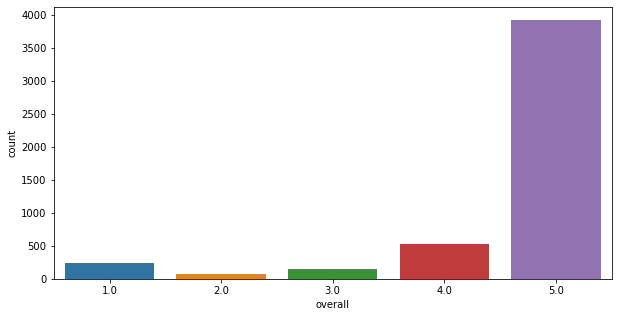

###################################################################################



In [220]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       'Ratio': round(100*(dataframe[col_name].value_counts()) / len(dataframe), 2)}))
    
    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show()
        
    print('###################################################################################\n')

plt.figure(figsize=(10, 5))
cat_summary(df, 'overall', plot=True)

**Max and min date**

In [221]:
df['reviewTime'].agg({'min', 'max'})

min    2012-01-09
max    2014-12-07
Name: reviewTime, dtype: object

## Task 1: Rating the product

### Step 1: Average rating (overall)

In [222]:
df['overall'].mean()

4.587589013224822

### Step 2: Time-based weighted average

**Convert reviewtime to datetime object**

In [223]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

In [224]:
df.dtypes

reviewerID                object
asin                      object
reviewerName              object
helpful                   object
reviewText                object
overall                  float64
summary                   object
unixReviewTime             int64
reviewTime        datetime64[ns]
day_diff                   int64
helpful_yes                int64
total_vote                 int64
dtype: object

**Calculate current date**

In [225]:
current_date = df['reviewTime'].max()
current_date

Timestamp('2014-12-07 00:00:00')

**Create 'days' column**

In [226]:
df['days'] = (current_date - df['reviewTime']).dt.days

In [227]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0000,Four Stars,1406073600,2014-07-23,138,0,0,137
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,408
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0000,nothing to really say....,1356220800,2012-12-23,715,0,0,714
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,381
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0000,best deal around,1373673600,2013-07-13,513,0,0,512


**Calculate the quantiles**

In [228]:
quantiles = df['days'].quantile(q=[0.05, 0.25, 0.7])
quantiles

0.0500    97.0000
0.2500   280.0000
0.7000   561.8000
Name: days, dtype: float64

In [229]:
q1 = quantiles.iloc[0]
q2 = quantiles.iloc[1]
q3 = quantiles.iloc[2]

**Less than q1 (97 days)**

In [230]:
df[df['days'] <= 90]['overall'].agg(['mean', 'count'])

mean      4.7824
count   193.0000
Name: overall, dtype: float64

**Between q1 (97 days) and q2 (280 days)**

In [231]:
df[(df['days'] > q1) & (df['days'] <= q2)]['overall'].agg(['mean', 'count'])

mean      4.6814
count   973.0000
Name: overall, dtype: float64

**Between q2 (280 days) and q2 (561 days)**

In [232]:
df[(df['days'] > q2) & (df['days'] <= q3)]['overall'].agg(['mean', 'count'])

mean       4.6093
count   2204.0000
Name: overall, dtype: float64

**Greater than q3 (561 days)**

In [233]:
df[df['days'] > q3]['overall'].agg(['mean', 'count'])

mean       4.4644
count   1475.0000
Name: overall, dtype: float64

**Calculate the time-based weighted average**

In [234]:
def time_based_weighted_average(dataframe, w1=28, w2=26, w3=24, w4=22): 
    
    rating = dataframe[dataframe['days'] <= q1]['overall'].mean() * w1 + \
    dataframe[(dataframe['days'] > q1) & (dataframe['days'] <= q2)]['overall'].mean() * w2 + \
    dataframe[(dataframe['days'] > q2) & (dataframe['days'] <= q3)]['overall'].mean() * w3 + \
    dataframe[dataframe['days'] > q3]['overall'].mean() * w4 
    
    return rating / 100

In [235]:
time_based_weighted_average(df, w1=28, w2=26, w3=24, w4=22)

4.635309938149424

## Task 2: Sorting top 20 reviews

### Step 1: Create a 'helpful_no' variables

In [236]:
df['helpful_no'] = df['total_vote'] - df['helpful_yes']

In [237]:
df['helpful_no'].value_counts()

0      4674
1       175
2        43
3         7
27        2
4         2
6         2
73        1
8         1
10        1
68        1
110       1
183       1
77        1
126       1
14        1
9         1
Name: helpful_no, dtype: int64

### Step 2: Calculate the score_pos_neg_diff, score_average_rating, wilson_lower_bound

**Define a function called score_pos_neg_diff that calculate the difference between positive and negative reviews**

In [238]:
def score_pos_neg_diff(pos, neg):
    return pos - neg

In [239]:
df['score_pos_neg_diff'] = df.apply(lambda x: score_pos_neg_diff(x['helpful_yes'], x['helpful_no']), axis=1)

**Define a function called score_average_rating that calculate the positive percentage reviews**

In [240]:
def score_average_rating(up, down):
    if (up + down) == 0:
        return 0
    return up / (up + down)

In [241]:
df['score_average_rating'] = df.apply(lambda x: score_average_rating(x['helpful_yes'], x['helpful_no']), axis=1)

**Wilson lower bound function**

In [242]:
def wilson_lower_bound(up, down, confidence=0.95):
    
    n = up + down
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * up / n
    score = (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)
    
    return score

In [243]:
df['wilson_lower_bound'] = df.apply(lambda x: wilson_lower_bound(x['helpful_yes'], x['helpful_no']), axis=1)

### Step 3: Sort dataframe

**Sort dataframe by score_pos_neg_diff**

In [244]:
df.sort_values('score_pos_neg_diff', ascending=False).head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.0000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,701,68,1884,0.9663,0.9575
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.0000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,578,126,1442,0.9256,0.9121
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.0000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,802,77,1351,0.9488,0.9365
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.0000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1032,73,349,0.8525,0.8186
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.0000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,776,27,85,0.8058,0.7321
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.0000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,806,27,55,0.7523,0.6636
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.0000,I own it,1393545600,2014-02-28,283,60,68,282,8,52,0.8824,0.7847
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.0000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,157,4,41,0.9184,0.8081
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.0000,Awesome Card!,1339200000,2012-09-06,823,51,65,822,14,37,0.7846,0.6703
315,A2J26NNQX6WKAU,B007WTAJTO,"Amazon Customer ""johncrea""","[38, 48]",Bought this card to use with my Samsung Galaxy...,5.0000,Samsung Galaxy Tab2 works with this card if re...,1344816000,2012-08-13,847,38,48,846,10,28,0.7917,0.6574


**Sort dataframe by wilson_lower_bound**

In [246]:
df.sort_values('wilson_lower_bound', ascending=False).head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.0000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,701,68,1884,0.9663,0.9575
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.0000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,802,77,1351,0.9488,0.9365
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.0000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,578,126,1442,0.9256,0.9121
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.0000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1032,73,349,0.8525,0.8186
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.0000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,157,4,41,0.9184,0.8081
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.0000,I own it,1393545600,2014-02-28,283,60,68,282,8,52,0.8824,0.7847
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.0000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,776,27,85,0.8058,0.7321
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.0000,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,648,3,19,0.8800,0.7004
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.0000,Awesome Card!,1339200000,2012-09-06,823,51,65,822,14,37,0.7846,0.6703
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.0000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,806,27,55,0.7523,0.6636
